# Let's explore the RFX MDSplus tree

## Importing and setting up stuff

In [10]:
import MDSplus as mds
import numpy as np
import matplotlib.pyplot as plt
import sys, os, time, random
from tqdm import tqdm
print(f'Python version: {sys.version}')
print(f'MDSplus version: {mds.__version__}')

Python version: 3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 06:08:53) 
[GCC 9.4.0]
MDSplus version: 1.0.0


In [11]:
#color the terminal output
def pick_random_color():
    return '\033[38;5;{}m'.format(random.randint(8, 230))
ENDC = '\033[0m'

In [12]:
# define the shot number and tree
SHOT = 30810
rfx = mds.Tree('rfx', SHOT, 'readonly') # open the tree read-only

## Traversing the tree

In [13]:
MAX_DEPTH = 5 # maximum depth of the tree to traverse
COLORS = [pick_random_color() for i in range(MAX_DEPTH)]

def traverse_tree_depth_first(max_depth, node, level=0, path='', node_type='child'):
    try: 
        if level >= max_depth: return # stop if the maximum depth is reached
        if node_type == 'child': node_name = node.node_name.upper()
        elif node_type == 'member': node_name = node.node_name.lower()
        else: raise ValueError('node_type must be either "child" or "member"') 
        path = path + '/' + COLORS[level] + node_name + ENDC # add the node name
        print(f'{path}:{node.decompile()}') 
        # go through the children and members of the node
        for child in node.getChildren(): # get the children of the node
            traverse_tree_depth_first(max_depth, child, level + 1, path, 'child')
        for member in node.getMembers(): # get the members of the node
            traverse_tree_depth_first(max_depth, member, level + 1, path, 'member')
    except Exception as e:
        print(path + 'ERR:' + str(e))
        pass

# do the same but without recursion
def traverse_tree_breadth_first(max_depth, head_node):
    curr_nodes = [head_node]
    for d in range(max_depth):
        print('Depth:', d)
        next_nodes = []
        for node in curr_nodes:
            try:
                preprint = COLORS[d] + "   " * d + node.node_name + ENDC
                print(f'{preprint}:{node.decompile()}') # print the node
                # get the children of the node
                for child in node.getChildren():
                    next_nodes.append(child)
                # get the members of the node
                for member in node.getMembers():
                    next_nodes.append(member)
            except: pass
        curr_nodes = next_nodes
        
head_node = rfx.getNode('\\TOP.RFX') # get the top node

# test the functions, uncomment to run
# traverse_tree_depth_first(MAX_DEPTH, head_node) # traverse the tree depth-first
# traverse_tree_breadth_first(MAX_DEPTH, head_node) # traverse the tree breadth-first

In [14]:
print(f'top nodes: {[n.node_name for n in head_node.getChildren()]}')

top nodes: ["ACTIONS", "DIAG", "EDA", "MHD", "SETUP", "STC", "VERSIONS"]


## Exploring Signals

In [15]:
# search_space = '\\TOP.RFX.MHD.***' # *** means all nodes at this level
search_space = '\\TOP.RFX.EDA.***' # * means all nodes at this level
# search_space = '\\TOP.RFX.***' # whole rfx tree
signal_nodes = rfx.getNodeWild(search_space, 'Signal') # get all nodes with the name 'Signal'
print(f'Found {len(signal_nodes)} of the type Signal in the search space {search_space}')

Found 7547 of the type Signal in the search space \TOP.RFX.EDA.***


In [16]:
# filter out the nodes without the data
data_signals = []
for node in tqdm(signal_nodes, leave=False):
    try: data = node.data(); data_signals.append(node)
    except Exception as e: pass
print(f'Found {len(data_signals)} signals with data')

Found 3652 signals with data


In [17]:
# keep only the signals with raw data
raw_signals = []
for node in tqdm(signal_nodes, leave=False):
    try: data = node.raw_of().data(); raw_signals.append(node)
    except Exception as e: pass
print(f'Found {len(raw_signals)} signals with raw data')

Found 3575 signals with raw data


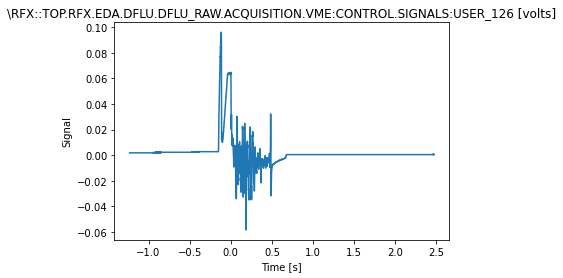

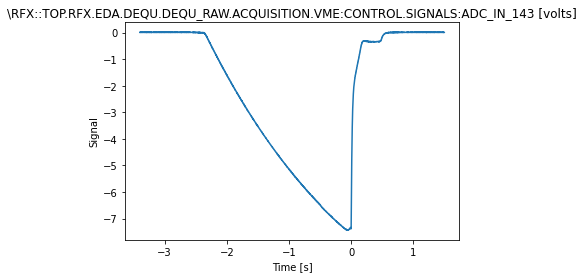

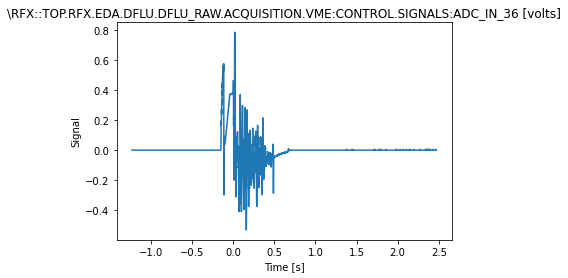

In [18]:
# extract data from the signals
MAX_LOAD = 3
# select MAX_LOAD random signals
signals = random.sample(raw_signals, MAX_LOAD)
for node in signals:
    try:
        signal = node.data()
        times = node.dim_of().data()
        unit = node.getUnits()
        full_path = node.getFullPath()
        assert signal.shape == times.shape, f'signal and times shapes do not match: {signal.shape} != {times.shape}'
        # plot the signal
        plt.figure()
        plt.plot(times, signal)
        plt.title(f'{full_path} [{unit}]')
        plt.xlabel('Time [s]')
        plt.ylabel('Signal')
        plt.show()
        # print(f'{node.node_name}: {data.shape}')
    except Exception as e: print(f'{node.node_name}: {e}')